### Imports

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
import warnings
import glob
import random
import cv2
from random import shuffle

warnings.filterwarnings(action='ignore')

Using TensorFlow backend.


In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

### Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True:     
    batch = np.random.choice(files, size = batch_size)    
    
    batch_x = []
    batch_y = []
    
    for f in batch:

        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]

        batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)

    yield (batch_x, batch_y)      

In [0]:
batch_size = 32 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [8]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 2)


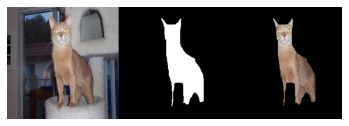

In [9]:
plt.axis('off')
img = x[0]
msk = y[0]

msk = msk[:,:,1]

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Model

In [0]:
def unet(sz = (256, 256, 3)):
    x = Input(sz)
    inputs = x
    nKernels = 8
    layers = []

    layer11 = Conv2D(nKernels, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (x)
    layer11 = BatchNormalization()(layer11)
    layer11 = LeakyReLU()(layer11)
  

    layer12 = Conv2D(nKernels*2, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer11)
    layer12 = BatchNormalization()(layer12)
    layer12 = LeakyReLU()(layer12)
    layers.append(layer12)
    
    layer13 = MaxPooling2D() (layer12)
    
    layer21 = Conv2D(nKernels*2, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer13)
    layer21 = BatchNormalization()(layer21)
    layer21 = LeakyReLU()(layer21)
    
    layer22 = Conv2D(nKernels*4, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer21)
    layer22 = BatchNormalization()(layer22)
    layer22 = LeakyReLU()(layer22)
    layers.append(layer22)
    
    layer23 = MaxPooling2D() (layer22)
    
    layer31 = Conv2D(nKernels*4, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer23)
    layer31 = BatchNormalization()(layer31)
    layer31 = LeakyReLU()(layer31)
    
    layer32 = Conv2D(nKernels*8, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer31)
    layer32 = BatchNormalization()(layer32)
    layer32 = LeakyReLU()(layer32)
    layers.append(layer32)
    
    layer33 = MaxPooling2D() (layer32)

    layer41 = Conv2D(nKernels*8, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer33)
    layer41 = BatchNormalization()(layer41)
    layer41 = LeakyReLU()(layer41)
    
    layer42 = Conv2D(nKernels*16, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer41)
    layer42 = BatchNormalization()(layer42)
    layer42 = LeakyReLU()(layer42)
    layers.append(layer42)
    
    layer43 = MaxPooling2D() (layer42)
    
    layer51 = Conv2D(nKernels*16, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer43)
    layer51 = BatchNormalization()(layer51)
    layer51 = LeakyReLU()(layer51)
    
    layer52 = Conv2D(nKernels*32, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer51)
    layer52 = BatchNormalization()(layer52)
    layer52 = LeakyReLU()(layer52)
    layers.append(layer52)
    
    layer53 = MaxPooling2D() (layer52)

    layer61 = Conv2D(nKernels*32, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer53)
    layer61 = BatchNormalization()(layer61)
    layer61 = LeakyReLU()(layer61)
    
    layer62 = Conv2D(nKernels*64, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer61)
    layer62 = BatchNormalization()(layer62)
    layer62 = LeakyReLU()(layer62)
    layers.append(layer62)
    
    layer63 = MaxPooling2D() (layer62)
    
    bottleneck11 = Conv2D(nKernels*64, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer63)
    bottleneck11 = BatchNormalization()(bottleneck11)
    bottleneck11 = LeakyReLU()(bottleneck11)
    
    bottleneck12 = Conv2D(nKernels*64, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (bottleneck11)
    bottleneck12 = BatchNormalization()(bottleneck12)
    bottleneck12 = LeakyReLU()(bottleneck12)
    
    bottleneck13 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  
    level = len(layers) - 1
    layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  
    layer72 = Conv2D(nKernels*32, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer71)
    layer72 = BatchNormalization()(layer72)
    layer72 = LeakyReLU()(layer72)
    
    layer73 = Conv2D(nKernels*16, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer72)
    layer73 = BatchNormalization()(layer73)
    layer73 = LeakyReLU()(layer73)
    
    layer74 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer73)
    level = len(layers) - 2
    
    layer81 = Concatenate(axis=3)([layer74, layers[level]])
  
  
    layer82 = Conv2D(nKernels*16, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer81)
    layer82 = BatchNormalization()(layer82)
    layer82 = LeakyReLU()(layer82)
    
    layer83 = Conv2D(nKernels*16, 3, activation=None, use_bias=False, kernel_initializer='he_normal',  padding='same') (layer82)
    layer83 = BatchNormalization()(layer83)
    layer83 = LeakyReLU()(layer83)
    
    layer84 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer83)
    level = len(layers) - 3
    
    layer91 = Concatenate(axis=3)([layer84, layers[level]])

    layer92 = Conv2D(nKernels*8, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer91)
    layer92 = BatchNormalization()(layer92)
    layer92 = LeakyReLU()(layer92)
    
    layer93 = Conv2D(nKernels*8, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer92)
    layer93 = BatchNormalization()(layer93)
    layer93 = LeakyReLU()(layer93)
    
    layer94 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer93)
    level = len(layers) - 4
    
    layer101 = Concatenate(axis=3)([layer94, layers[level]])
  
    layer102 = Conv2D(nKernels*4, 3, activation=None, use_bias=False, kernel_initializer='he_normal',  padding='same') (layer101)
    layer102 = BatchNormalization()(layer102)
    layer102 = LeakyReLU()(layer102)
    
    layer103 = Conv2D(nKernels*4, 3, activation=None, use_bias=False, kernel_initializer='he_normal',  padding='same') (layer102)
    layer103 = BatchNormalization()(layer103)
    layer103 = LeakyReLU()(layer103)
    
    layer104 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer103)
    level = len(layers) - 5
    
    layer111 = Concatenate(axis=3)([layer104, layers[level]])
    
    layer112 = Conv2D(nKernels*2, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer111)
    layer112 = BatchNormalization()(layer112)
    layer112 = LeakyReLU()(layer112)
    
    layer113 = Conv2D(nKernels*2, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer112)
    layer113 = BatchNormalization()(layer113)
    layer113 = LeakyReLU()(layer113)
    
    layer114 = Conv2DTranspose(nKernels, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer113)
    level = len(layers) - 6
    
    layer121 = Concatenate(axis=3)([layer114, layers[level]])
      
    classification1 = Conv2D(nKernels, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (layer121)
    classification1 = LeakyReLU()(classification1)
    classification1 = Dropout(0.25)(classification1)
    
    classification2 = Conv2D(nKernels, 3, activation=None, use_bias=False, kernel_initializer='he_normal', padding='same') (classification1)
    classification2 = LeakyReLU()(classification2)
    outputs = Conv2D(2, 1, activation='softmax') (classification2)
  
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = [dice_coef])
  
    return model

In [12]:
model = unet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        pred = model.predict(np.expand_dims(raw, 0))
        
        msk = np.argmax(pred, axis=-1)
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
    
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [14]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

print (train_steps, test_steps)

219 11


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
i= 1 loss= 0.3952088794207464 val_loss= 1.4034373435107144 mean_dsc= 0.683818 val_mean_dsc= 0.59123147


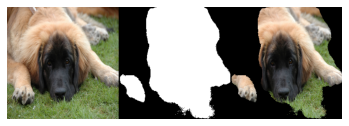

i= 2 loss= 0.2712159895733611 val_loss= 0.34669840877706354 mean_dsc= 0.8078717 val_mean_dsc= 0.8229883


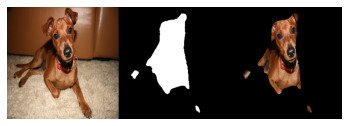

i= 3 loss= 0.22955330498686663 val_loss= 0.26443196020343085 mean_dsc= 0.8388586 val_mean_dsc= 0.8392414


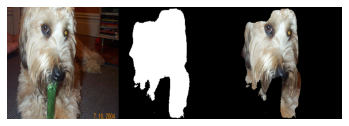

i= 4 loss= 0.20288540803950672 val_loss= 0.2407903251322833 mean_dsc= 0.8576887 val_mean_dsc= 0.8553133


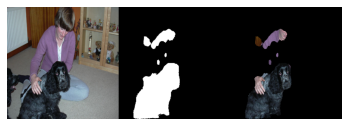

i= 5 loss= 0.1825009474199112 val_loss= 0.23012120479887183 mean_dsc= 0.87376773 val_mean_dsc= 0.8405911


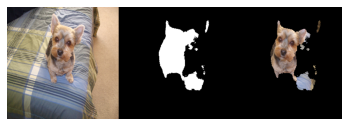

i= 6 loss= 0.17565207612024594 val_loss= 0.22547456215728412 mean_dsc= 0.8776494 val_mean_dsc= 0.8529638


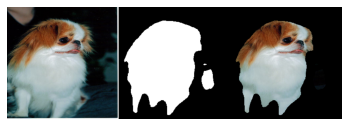

i= 7 loss= 0.16553068184825384 val_loss= 0.1841081611134789 mean_dsc= 0.8880818 val_mean_dsc= 0.87999576


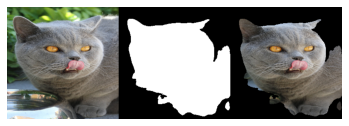

i= 8 loss= 0.1581325557542174 val_loss= 0.19968099350279028 mean_dsc= 0.89165837 val_mean_dsc= 0.86583424


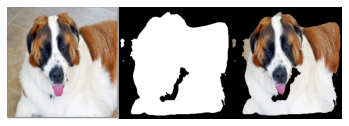

i= 9 loss= 0.15159370950912232 val_loss= 0.2287272201343016 mean_dsc= 0.8949912 val_mean_dsc= 0.87043023


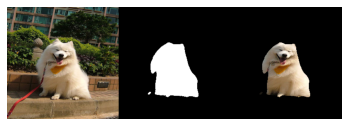

i= 10 loss= 0.14377811421814574 val_loss= 0.19079433584755118 mean_dsc= 0.9017915 val_mean_dsc= 0.87712383


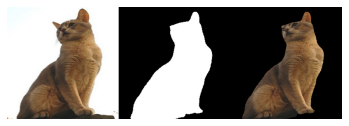

i= 11 loss= 0.14123010669396893 val_loss= 0.1622660607099533 mean_dsc= 0.90396684 val_mean_dsc= 0.88815045


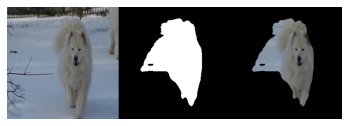

i= 12 loss= 0.13749793777454933 val_loss= 0.1882339675318111 mean_dsc= 0.9061373 val_mean_dsc= 0.88308275


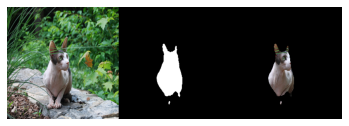

i= 13 loss= 0.12914745363334543 val_loss= 0.16407291997562756 mean_dsc= 0.9120213 val_mean_dsc= 0.8878102


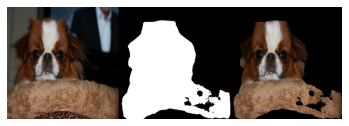

i= 14 loss= 0.12606510431527002 val_loss= 0.16770809956572272 mean_dsc= 0.91417 val_mean_dsc= 0.8821278


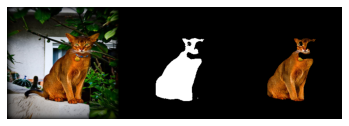

i= 15 loss= 0.1203395349726285 val_loss= 0.17269211194731973 mean_dsc= 0.9184109 val_mean_dsc= 0.8713842


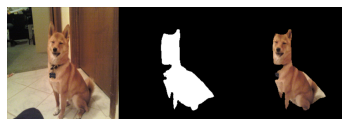

i= 16 loss= 0.11604791947695763 val_loss= 0.15987396917559885 mean_dsc= 0.9209563 val_mean_dsc= 0.88920635


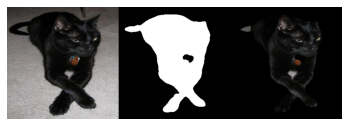

i= 17 loss= 0.11538281216877236 val_loss= 0.14760785008018668 mean_dsc= 0.92164934 val_mean_dsc= 0.8987705


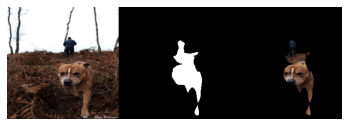

i= 18 loss= 0.11129308376274152 val_loss= 0.15459481829946692 mean_dsc= 0.9250595 val_mean_dsc= 0.89675707


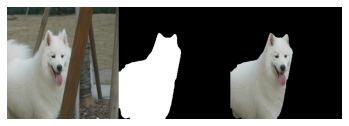

i= 19 loss= 0.1089245308888013 val_loss= 0.1923429315740412 mean_dsc= 0.92570496 val_mean_dsc= 0.87209475


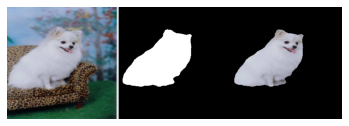

i= 20 loss= 0.10812377123391792 val_loss= 0.1541627902876247 mean_dsc= 0.926961 val_mean_dsc= 0.8988745


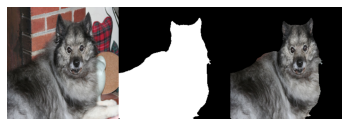

i= 21 loss= 0.10169235943523172 val_loss= 0.16032736816189505 mean_dsc= 0.9305333 val_mean_dsc= 0.890498


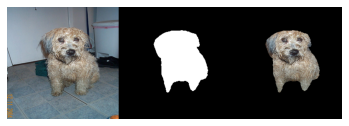

i= 22 loss= 0.09947260741365554 val_loss= 0.16382254524664444 mean_dsc= 0.9322272 val_mean_dsc= 0.89464396


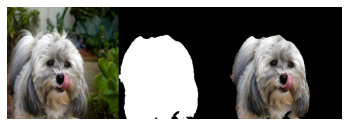

i= 23 loss= 0.09901512642157133 val_loss= 0.13863799517804926 mean_dsc= 0.93221873 val_mean_dsc= 0.8995388


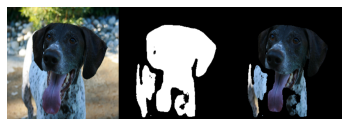

i= 24 loss= 0.0970145548315353 val_loss= 0.1413480124690316 mean_dsc= 0.9338005 val_mean_dsc= 0.89126205


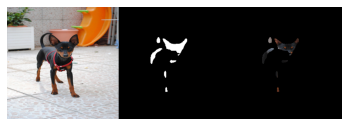

i= 25 loss= 0.09448674732827705 val_loss= 0.1840989129109816 mean_dsc= 0.93549955 val_mean_dsc= 0.8819988


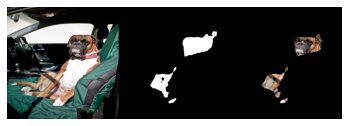

i= 26 loss= 0.09191117316620535 val_loss= 0.15276046165011145 mean_dsc= 0.93664455 val_mean_dsc= 0.9069174


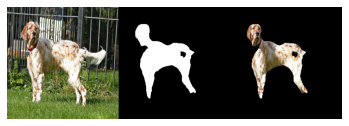

i= 27 loss= 0.0901743665541688 val_loss= 0.1353002427653833 mean_dsc= 0.9380925 val_mean_dsc= 0.90263885


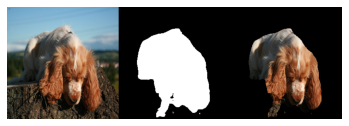

i= 28 loss= 0.08983080493941155 val_loss= 0.14749241146174344 mean_dsc= 0.93831414 val_mean_dsc= 0.90715444


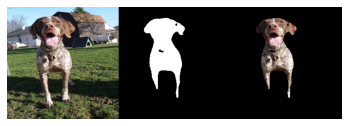

i= 29 loss= 0.08730618009284206 val_loss= 0.1792978048324585 mean_dsc= 0.93881935 val_mean_dsc= 0.8847647


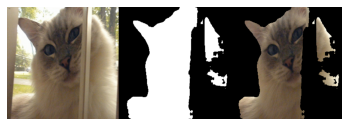

i= 30 loss= 0.08524376359772465 val_loss= 0.16612307185476477 mean_dsc= 0.94135416 val_mean_dsc= 0.89236337


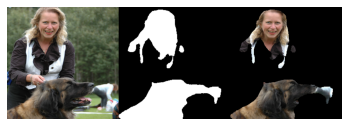

In [15]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps, callbacks = build_callbacks(), verbose = 0)

In [16]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-09 12:22:41--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.84.251.55, 99.84.251.83, 99.84.251.2, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.84.251.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-05-09 12:22:42 (4.15 MB/s) - ‘test.jpg’ saved [63219/63219]



### Testing

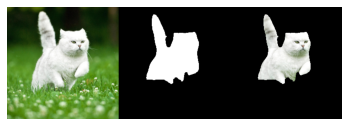

In [17]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

pred = model.predict(np.expand_dims(raw, 0))

msk = np.argmax(pred, axis=-1)
msk  = msk.squeeze()
msk = np.stack((msk,)*3, axis=-1)

combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()